# Test using the log marginal likelihood to estimate GP parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from scipy import signal
from scipy.sparse import linalg as sla
from scipy import linalg as la
from scipy.optimize import minimize
from tqdm import tqdm

from oceanoi import cov, oi, variogram

In [2]:
plt.rcParams['pcolor.shading'] = 'auto'

In [12]:
# Create a dataset for a propagating (soliton-like) signal
def rotate_xy_deg(xin, yin, thetadeg):
    theta = np.pi*thetadeg/180
    cost = np.cos(theta)
    sint = np.sin(theta)
    return xin*cost - yin*sint, xin*sint + yin*cost

#####
# parameters
a0=0.5
lx = 1600.
ly = 600.
thetadeg = 60.
c = 1.0
x0 = -500.
y0 = -500.

tmax = 3600.

dx = 100
dt = 120.

######
thetarad = np.pi*thetadeg/180
x = np.arange(0, tmax*c, dx)
y = np.arange(0, tmax*c+2*dx, dx)
t = np.arange(0, tmax, dt)

X,Y,T = np.meshgrid(x,y,t)
Xr, Yr = rotate_xy_deg(X, Y, thetadeg)
cx = c*np.cos(thetarad)
cy = c*np.sin(thetarad)

u = -a0* \
    np.exp( -( (Xr-x0)**2/lx**2 + 
          (Yr-c*T-y0)**2/ly**2 
        ) )\
    + 0.01*np.random.normal(size=X.shape)
    
# u = -a0* \
#     np.exp( -( (X-cx*T-x0)**2/lx**2 + 
#           (Y-cy*T-y0)**2/ly**2 +
#           (X-cx*T-x0)*(Y-cy*T-y0)/(lx*ly*np.cos(thetarad))    
#         ) )\
#     + 0.01*np.random.normal(size=X.shape)
    



plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')
u.shape, y.shape, x.shape, t.shape


((38, 36, 30), (38,), (36,), (30,))

CPU times: user 30.6 ms, sys: 7.06 ms, total: 37.6 ms
Wall time: 28.9 ms


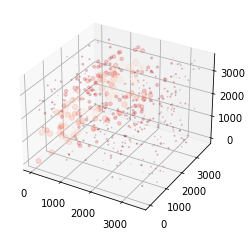

In [13]:
%%time
# Take a random sample of the data for a 2D 
ny,nx,nt = u.shape
nsamples = 500
rr = np.random.randint(ny,size=nsamples)
cc = np.random.randint(nx,size=nsamples)
ii = np.random.randint(nt,size=nsamples)

xd = X[rr,cc,ii]
yd = Y[rr,cc,ii]
td = T[rr,cc,ii]

Z = u[rr,cc,ii]

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xd,yd,zs=td,s=np.abs(Z)*100,c=Z, cmap='Reds',alpha=0.2)

In [14]:
%%time
# Create a 3D OI object

scale = 1e-3
# covfunc = cov.rotated_expquad_cov_3d
covfunc = cov.rotated_matern52_cov_3d

covparams = (0.01, 1., 1.0, 1., 0.,0.,0.)
noise = 0.01


OI = oi.OptimalInterp3D(xd*scale, yd*scale, td*scale, \
                            xd*scale, yd*scale, td*scale,\
                            noise, covfunc, covparams)

CPU times: user 121 ms, sys: 46.2 ms, total: 168 ms
Wall time: 133 ms


In [15]:
OI.neg_log_marginal_likelihood(xd*scale, yd*scale, td*scale, Z, noise, covfunc, covparams)

39844.96774683554

In [16]:
covparams = (0.01, 1.,5.0, 1., 0.2,0.,0.)
OI.neg_log_marginal_likelihood(xd*scale, yd*scale, td*scale, Z, noise, covfunc, covparams)

43848.28310979811

In [17]:
# minimize?

In [20]:
# Minimize the log marginal likelihood
def minfunc(params, x, y, t, Z, noise, covfunc):
    nll= OI.neg_log_marginal_likelihood(x,y,t, Z, noise, covfunc, params)
    print(nll, params)
    return nll

pi2 = np.pi/2.
method = 'powell'
bounds =  ((1e-3,0.2), (3*dx*scale,50), (3*dx*scale,50), (3*dt*scale,10), (0,pi2), (0,pi2), (0,pi2)) 
bounds=None
options = {'eps':1e-7}
covparams = (0.01, 2., 1.0, 0.5, 0.1,0.5,1.1)



def optlog(x):
    print(x)

soln = minimize(minfunc, covparams,
         args=(xd*scale, yd*scale, td*scale, Z, noise, covfunc),
            method=method,
            bounds=bounds,
            options=options,
            callback=None,
         ) 
soln

<ipython-input-20-bd29e583958d>:19: OptimizeWarning: Unknown solver options: eps
  soln = minimize(minfunc, covparams,


39617.81977761438 [0.01 2.   1.   0.5  0.1  0.5  1.1 ]
39617.81977761438 [0.01 2.   1.   0.5  0.1  0.5  1.1 ]
940.970072058456 [1.01 2.   1.   0.5  0.1  0.5  1.1 ]
769.9333599587749 [2.628034 2.       1.       0.5      0.1      0.5      1.1     ]
718.7193422555478 [1.82260444 2.         1.         0.5        0.1        0.5
 1.1       ]
718.7193422555478 [1.82260444 2.         1.         0.5        0.1        0.5
 1.1       ]
735.8131278772299 [1.51221717 2.         1.         0.5        0.1        0.5
 1.1       ]
729.4230817664966 [2.13025115 2.         1.         0.5        0.1        0.5
 1.1       ]
718.938047122624 [1.85678784 2.         1.         0.5        0.1        0.5
 1.1       ]
718.7315203534499 [1.80447839 2.         1.         0.5        0.1        0.5
 1.1       ]
718.7193422555478 [1.82260444 2.         1.         0.5        0.1        0.5
 1.1       ]
843.4422012980436 [1.82260444 3.         1.         0.5        0.1        0.5
 1.1       ]
978.7759636401595 [1.82260

/home/suntans/miniconda3/envs/sfoda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


809.5693264120952 [1.82260444 1.64942733 1.05178497 0.26393203 0.1        0.5
 1.1       ]
706.7425930317739 [1.82260444 1.64942733 1.05178497 0.51124088 0.1        0.5
 1.1       ]
706.1134533871963 [1.82260444 1.64942733 1.05178497 0.49360374 0.1        0.5
 1.1       ]
706.1112330813273 [1.82260444 1.64942733 1.05178497 0.4924643  0.1        0.5
 1.1       ]
706.1112349302762 [1.82260444 1.64942733 1.05178497 0.49253966 0.1        0.5
 1.1       ]
706.1112517781685 [1.82260444 1.64942733 1.05178497 0.49238894 0.1        0.5
 1.1       ]
706.1112330813273 [1.82260444 1.64942733 1.05178497 0.4924643  0.1        0.5
 1.1       ]
700.5569091298163 [1.82260444 1.64942733 1.05178497 0.4924643  1.1        0.5
 1.1       ]
713.45672369073 [1.82260444 1.64942733 1.05178497 0.4924643  2.718034   0.5
 1.1       ]
700.5569091298163 [1.82260444 1.64942733 1.05178497 0.4924643  1.1        0.5
 1.1       ]
723.2217056931713 [1.82260444 1.64942733 1.05178497 0.4924643  1.71803397 0.5
 1.1       ]
6

/home/suntans/code/oceanoi/oceanoi/cov.py:24: RuntimeWarning: overflow encountered in exp
  return (1 + fac2/l + fac1/(3*l*l) )*np.exp(-fac2/l)
/home/suntans/code/oceanoi/oceanoi/cov.py:24: RuntimeWarning: overflow encountered in multiply
  return (1 + fac2/l + fac1/(3*l*l) )*np.exp(-fac2/l)


660.7869430922169 [0.08715057 0.07291963 0.30149815 0.95214557 0.70432217 0.08622345
 4.03713853]
387.92386806166667 [0.20136957 0.05082873 0.30476132 0.95167072 0.74070603 0.14779972
 4.02808118]
377.94064884414536 [0.13371561 0.06391356 0.30282849 0.95195198 0.71915522 0.11132699
 4.03344601]
360.4698990629312 [0.16378505 0.05809789 0.30368755 0.95182697 0.72873368 0.12753763
 4.03106156]
359.8988946913689 [0.15953719 0.05891946 0.30356619 0.95184463 0.72738055 0.12524759
 4.03139841]
361.7808592352236 [0.14967423 0.06082704 0.30328442 0.95188564 0.72423875 0.11993039
 4.03218052]
359.87513683957104 [0.15832747 0.05915343 0.30353163 0.95184966 0.72699519 0.12459541
 4.03149434]
359.8745611840417 [0.15847135 0.0591256  0.30353574 0.95184906 0.72704103 0.12467298
 4.03148293]
359.87456622912 [0.15851158 0.05911782 0.30353689 0.9518489  0.72705384 0.12469467
 4.03147974]
359.87462860499477 [0.15843112 0.05913338 0.30353459 0.95184923 0.72702821 0.12465129
 4.03148612]
359.8745611840417 

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.97252651e-01,  3.81502916e-02, -5.63538453e-03,
         8.20055803e-04, -6.28337799e-02, -1.06340300e-01,
         1.56417700e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-5.75305248e-01, -8.50104113e-01, -2.62548270e-01,
         2.05256092e-01, -1.00705446e-01, -3.84153660e-01,
        

In [21]:
# %%time
scale = 1e-3
# Optimal interpolation using "time-series" data i.e., from pseudo-moorings
ny,nx,nt = u.shape

# Example set of stations to extract time-series data from
cc = [10,20,30, 12]
rr = [5,15,22, 22]
# cc = [10,]
# rr = [22]

xd = X[rr,cc,:].ravel()
yd = Y[rr,cc,:].ravel()
td = T[rr,cc,:].ravel()
zd = u[rr,cc,:].ravel()

U_oi = np.zeros_like(X)
# Loop through each time point (this is purely to avoid a memory blowout)
#for ii in tqdm(range(nt)):
for ii in [0,14,28]:
    print(ii)
    #if ii%20==0:
    #    print(ii, X.shape[0])
        
    Xm = X[:,:,ii]
    Ym = Y[:,:,ii]
    Tm = T[:,:,ii]
    sd = 0.01
    OI = oi.OptimalInterp3D(xd*scale, yd*scale, td*scale, \
                            Xm.ravel()*scale, Ym.ravel()*scale, Tm.ravel()*scale,\
                            sd, covfunc, covparams)
    U_oi[...,ii] = OI(zd[:,None]).reshape((ny,nx))

# plt.figure()


0
14
28


Text(0.5, 1.0, 'T=28')

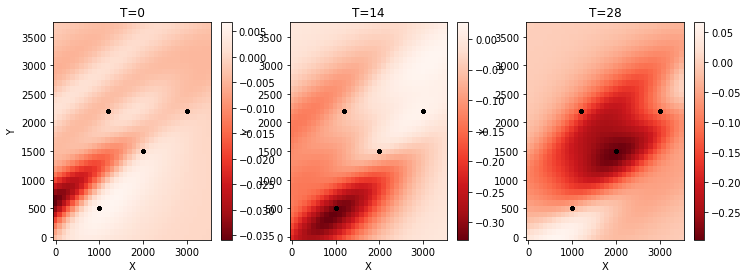

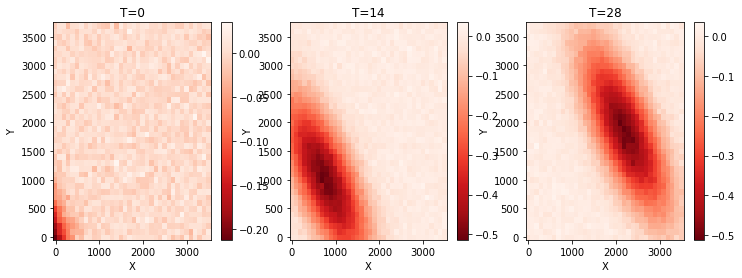

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],U_oi[:,:,0],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],U_oi[:,:,14],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],U_oi[:,:,28],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')


# Low rank approximation testing...

In [7]:
# Test out the SVD on the matrix K

def build_K(xd, yd, td, zd, sd, cov_func, cov_params):
    
    N = xd.shape[0]
    I = np.diag(np.ones((N)))
    
    return cov_func(xd[:,None], yd[:,None], td[:,None], xd[:,None].T, yd[:,None].T, td[:,None].T, cov_params)


In [8]:
K = build_K(xd*scale, yd*scale, td*scale, Z, 0, covfunc, covparams)

In [9]:
K.shape

(1000, 1000)

In [10]:
%%time
U, S, V = la.svd(K, check_finite=False, overwrite_a=False)

CPU times: user 1.05 s, sys: 591 ms, total: 1.65 s
Wall time: 465 ms


In [11]:
# Rank approx
k = 50
Uh = U[:,0:k]
Sh = S[0:k]
Vh = V[:,0:k]



In [12]:
%%time
# Try the sparse linalg library
U,S,V = sla.svds(K, k=k, which='LM')

CPU times: user 332 ms, sys: 322 ms, total: 654 ms
Wall time: 205 ms


In [13]:
U.shape, V.shape, Uh.shape, Vh.shape

((1000, 50), (50, 1000), (1000, 50), (1000, 50))

In [14]:
la.norm(Sh-S[::-1])


1.6416267385417356e-17

In [15]:
%%time
# Inverse
N = Uh.shape[0]

noise = 0.01
I = np.ones((N,))
Si = np.diag(1/Sh)
Ai = np.diag(1/(noise*I))

B =  Si + Vh.T @ Ai @ Uh
Bi = la.inv(B)

Ki = Ai - Ai @ Uh @ Bi @ Vh.T @ Ai

CPU times: user 232 ms, sys: 364 ms, total: 596 ms
Wall time: 194 ms


In [16]:
# Roll it into one function
def inv_lowrank(Kdd, sigma, k, method='sparse'):
    """
    Matrix inversion using the low rank approximation
    """
    
    if method=='sparse':
        # Use the sparse linalg library
        Uh,Sh,VhT = sla.svds(Kdd, k=k, which='LM')

        # Note that these are reversed order
        #Uh = Uh[:,::-1]
        #Vh = Vh[::-1,:] # V is transposed
        #Sh = Sh[::-1]
    else:
    
        U, S, V = la.svd(Kdd, check_finite=False, overwrite_a=False)
        Uh = U[:,0:k]
        Sh = S[0:k]
        VhT = V[:,0:k].T
    
    # Inverse
    N = Uh.shape[0]

    noise = 0.01
    I = np.ones((N,))
    Si = np.diag(1/Sh)
    Ai = np.diag(1/(sigma*I))
    
    B =  Si + VhT @ Ai @ Uh
    Bi = la.inv(B)

    Ki = Ai - Ai @ Uh @ Bi @ VhT @ Ai
    
    return Ki, Sh
    

In [17]:
%%time
Ki_s, Sh = inv_lowrank(K, noise, 100, method='scipy')

CPU times: user 1.24 s, sys: 1.2 s, total: 2.44 s
Wall time: 831 ms


In [18]:
%%time
Ki_sp, Sh_sp = inv_lowrank(K, noise, 100, method='sparse')

CPU times: user 873 ms, sys: 1.2 s, total: 2.07 s
Wall time: 561 ms


In [19]:
la.norm(Ki_s - Ki_sp, ord='fro')

384.3042094976409

In [20]:
Sh-Sh_sp[::-1]

array([ 6.93889390e-18, -6.93889390e-18,  3.46944695e-18,  5.20417043e-18,
        8.67361738e-19,  1.73472348e-18,  4.33680869e-18, -1.73472348e-18,
       -4.33680869e-19,  0.00000000e+00, -8.67361738e-19,  1.30104261e-18,
        1.08420217e-18,  2.16840434e-19,  1.08420217e-18,  0.00000000e+00,
       -8.67361738e-19,  2.16840434e-19, -6.50521303e-19, -2.16840434e-19,
       -4.33680869e-19, -7.58941521e-19, -7.58941521e-19,  6.50521303e-19,
        0.00000000e+00, -2.16840434e-19, -6.50521303e-19,  1.08420217e-19,
       -1.08420217e-19,  5.42101086e-20, -4.33680869e-19,  5.42101086e-20,
        1.62630326e-19, -5.42101086e-20,  5.96311195e-19,  5.42101086e-20,
        5.42101086e-20, -1.08420217e-19,  5.14996032e-19, -2.71050543e-20,
        2.71050543e-20,  8.94466792e-19,  3.79470760e-19, -1.35525272e-19,
        2.43945489e-19,  1.08420217e-19,  5.14996032e-19,  0.00000000e+00,
        8.13151629e-19,  2.30392962e-19,  3.93023288e-19,  1.08420217e-19,
        1.04354459e-18,  

In [21]:
weights = K.T @ Ki_sp
weights - OI.w_md

array([[-2.37862626e-02, -1.09932908e-04,  1.82685626e-03, ...,
        -6.36420545e-04, -1.38255929e-04,  1.56207772e-05],
       [-1.09932908e-04, -4.03693874e-02,  2.88872453e-03, ...,
         1.04278357e-04,  2.57606063e-04,  2.51878473e-04],
       [ 1.82685626e-03,  2.88872453e-03, -2.98436491e-02, ...,
         3.79112565e-05, -3.18269002e-04, -1.84032155e-04],
       ...,
       [-6.36420545e-04,  1.04278357e-04,  3.79112565e-05, ...,
        -5.29057527e-02,  3.71646521e-03,  1.13736317e-03],
       [-1.38255929e-04,  2.57606063e-04, -3.18269002e-04, ...,
         3.71646521e-03, -3.38616239e-02, -1.54289703e-02],
       [ 1.56207772e-05,  2.51878473e-04, -1.84032155e-04, ...,
         1.13736317e-03, -1.54289703e-02, -3.70852351e-02]])

In [22]:
%%time
la.det(np.diag(Sh))

CPU times: user 2.18 ms, sys: 0 ns, total: 2.18 ms
Wall time: 968 µs


0.0

In [25]:
%%time 
L = la.cholesky(K + 1e-7*np.eye(N))

CPU times: user 51.2 ms, sys: 78.8 ms, total: 130 ms
Wall time: 62.7 ms
